Universidad Simón Bolívar. \\
Departamento de Cómputo Científico. \\
CO-6612, Introducción a Redes Neuronales. \\
TDD 2020. \\
Prof. Minaya Villasana. \\
Amin Arriaga 16-10072. 
# **Tarea 5: RBF**

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from random import uniform, shuffle
from math import e, sqrt
from time import time

In [ ]:
# Montamos el drive para obtener los archivos 
# mnist_test.csv,   mnist_train.csv
from google.colab import drive
drive.mount('/content/drive')

## **Problema 1**
Aproxime los datos en la serie dada por spectra20.csv usando un aproximador universal. Repita el ejercicio utilizando la técnica de regularización variando el parámetro de regularización. Reporte el mejor resultado obtenido y su argumentación para que asi sea. Reporte para ambos casos el número de condición de la matriz asociada.

**Implementación del Aproximador Universal**

In [5]:
def Gaussian(r: [float], s: float = 1) -> float:
  """ 
  Funcion Gaussiana.
  INPUT:
    - r:  Variable.
    - s:  Parametro de dispersion.
  OUTPUT:
    - float:  e^(-r^2/(2sigma^2))
  """
  return e**(-np.dot(r, r)/(2*s**2))

def cond(M: [[float]], M_inv: [[float]] = None, norm = np.inf) -> float:
  """
  Numero de condicion de una matriz.
  INPUT:
    - M:  Matriz.
    - M_inv:  Inversa de la matriz ya precalculada. En caso de no tenerla
              se calculara dentro de la funcion. Valor predeterminado: None.
    - norm:   Normal de una matriz. Valor predeterminado: numpy.inf
  OUTPUT:
    - float:  ||M||_inf * ||M_inv||_inf
  """
  try:
    if M_inv == None:
      M_inv = np.linalg.pinv(M)
  except:
    return np.linalg.norm(M, ord=norm)*np.linalg.norm(M_inv, ord=norm)

def UniversalApprox(X: [[float]], Y: [float], s: float = 1, l: float = 0) -> ([float], float):
  """ 
  Aproximador Universal.
  INPUT:
    - X:  Arreglo de datos a interpolar.
    - Y:  Salida deseada de cada dato.
    - s:  Parametro de dispersion. Valor predeterminado: 1.
    - l:  Parametro de regularizacion. Valor predeterminado: 0.
  OUTPUT:
    - [float]:  Conjunto de pesos obtenidos.
    - float:    Numero de condicion de la matriz G.
  """
  N = len(X)
  G = []
  # Calculamos la matriz G.
  for i in range(N):
    G_i = []
    for j in range(N):
      G_i.append( Gaussian(X[i] - X[j], s = s) )
    G.append(G_i.copy())
  G = np.array(G) + l*np.identity(N)

  # Obtenemos la inversa de G.
  G_inv = np.linalg.pinv(G)
  return np.dot(G_inv, Y), cond(G, G_inv)

def predict(W: [float], X: [float], X_train: [[float]]):
  return np.dot(W, [Gaussian(X - X_i) for X_i in X_train])

In [6]:
def readCSV(file):
  """ Leer datos bidimensionales de un archivo .csv 

  Input: 
    file:   Nombre del archivo csv.
  Output:
    X: Primeras coordenadas de los datos.
    Y: Segundas coordenadas de los datos.
  """
  with open(file, newline='') as File:  
      reader = csv.reader(File)
      X = []
      Y = []
      for r in reader:
          X.append(np.array([float(r[0])]))
          Y.append(float(r[1]))
          
  return np.array(X), np.array(Y)

X, Y = readCSV("/content/drive/My Drive/Spectra20.csv")
X_r, Y_r = readCSV("/content/drive/My Drive/SpectraReal.csv")

In [ ]:
def problema1(*L: float):
  """ Permite ejecutar el problema 1 con distintos parametros de regularizacion.
  INPUT:
    - L:  Conjunto de parametros de regularizacion a probar.
  """
  for l_i in L:
    W, cond = UniversalApprox(X, Y, l=l_i)
    X_predict = np.array([np.array([i/100]) for i in range(500)])
    Y_predict = [predict(W, x_i, X) for x_i in X_predict]
    plt.plot(X, Y, 'o', label="Datos")
    plt.plot(X_r, Y_r, label="Curva Real")
    plt.plot(X_predict, Y_predict, label="Interpolacion")
    plt.xlim(0, 5)
    plt.ylim(0, 1.5)
    plt.title("Interpolacion obtenida con lambda = " + str(l_i))
    plt.legend()
    plt.show()
    print("Numero de condicion de la matriz (G + " + str(l_i) + "*I): ", cond, "\n")

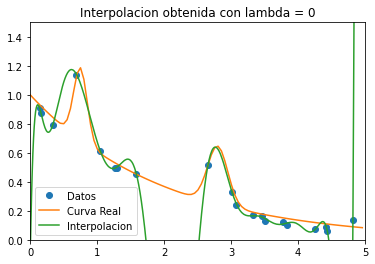

Numero de condicion de la matriz (G + 0*I):  1367193422684949.5 



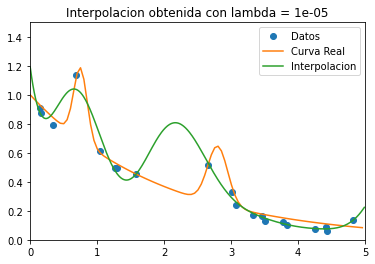

Numero de condicion de la matriz (G + 1e-05*I):  1971646.1298842533 



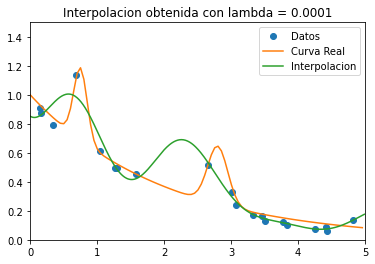

Numero de condicion de la matriz (G + 0.0001*I):  193324.04754330526 



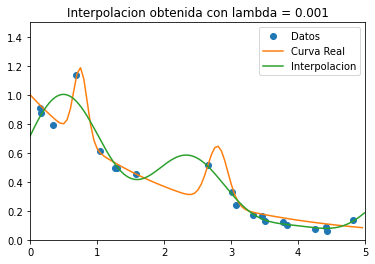

Numero de condicion de la matriz (G + 0.001*I):  19920.92561719011 



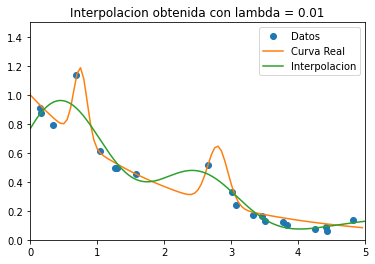

Numero de condicion de la matriz (G + 0.01*I):  2006.4863871440573 



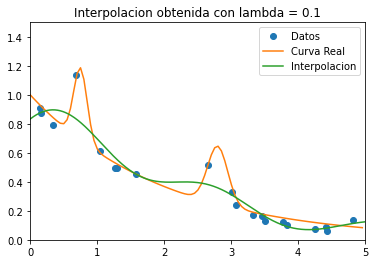

Numero de condicion de la matriz (G + 0.1*I):  196.03046509263962 



In [ ]:
problema1(0, 0.00001, 0.0001, 0.001, 0.01, 0.1)

Lo primero que se puede notar en los resultados es que cuando $\lambda = 0$ la interpolación cumple con su función de pasar por todos los datos de entrenamiento, pero en el resto de puntos la generalización es pobre, además el número de condicion es gigantesco. Considerando que se utilizo la pseudo-inversa, al usar la inversa la interpolación es desastrosa, llegando incluso a no pasar por los datos. Al agregarle un mínimo valor a $\lambda$ de $0.00001$, el cambio en los resultados es abismal, dando una curva mucha más aceptable y parecida a la original, a pesar de no pasar por todos los puntos. Además, el número de condición de la matriz baja en $9$ órdenes. Se nota claramente que al aumentar $\lambda$, disminuye el número de condición de $G$ y la curva se va haciendo mas suave, siendo para $\lambda = 0.0001$ donde se obtiene la mejor aproximación.

## **Problema 2**

### **Problema 2.a**
Aproxime los datos en la serie dada por spectra100.csv usando redes RBF. Deje fijo el parámetro de dispersión ($\sqrt{0.5}$) y experimente variando el número
de centros determinados ($i$) al azar y ($ii$) mediante un algoritmo de conglomerados. Comente sus resultados.

**Implementacón del RBF**

In [3]:
class RBF:
  """ Implementacion de las Redes de Base Radial (RBF). """

  def __init__(self, X: [[float]], Y: [float], s : float = 1):
    """
    INPUT:
      - X:   Conjunto de datos.
      - Y:   Valores deseados para el conjunto de datos.
      - s:   Parametro de dispersion.
    """
    self.X, self.Y, self.s = X, Y, s
    
    
  def obtain_Gaussian(self, t: [float]):
    """ Retorna una funcion Gaussiana centrada en un vector indicado t. """
    def Gaussian(X, t = t.copy()):
      s = self.s
      v = X - t
      return e**(-np.dot(v, v)/(2*(s**2)) )
    return Gaussian


  def get_centers_random(self, m: int):
    """
    Obtenemos centros aleatorios.
    INPUT:
        -m:   Numero de centros.
    """
    dim = len(self.X[0])
    # Obtenemos los minimos y maximos de cada coordenada en X.
    min_X = [min([x[i] for x in self.X]) for i in range(dim)]
    max_X = [max([x[i] for x in self.X]) for i in range(dim)]
    # Calculamos m centros aleatorios.
    self.centers = [np.array([uniform(min_X[i], max_X[i]) \
                              for i in range(dim)]) \
                    for _ in range(m)]
        
    # Obtenemos el conjunto de funciones gaussianas para los nuevos centros.
    self.phi = [self.obtain_Gaussian(t) for t in self.centers]
    
    
  def get_centers_cluster(self, m: int, e: float = 1, a: float = 1):
    """
    Obtenemos centros usando el metodo de clusters.
    INPUT:
      - m:   Numero de centros.
      - e:   Epsilon. Se seguiran actualizando los centros hasta que la actualizacion
             sea menor a este parametro.
      - a:   Parametro de actualizacion de los centros.
    """
    # Obtenemos los minimos y maximos de cada coordenada en X.
    min_X = [min([x[i] for x in self.X]) for i in range(len(self.X[0]))]
    max_X = [max([x[i] for x in self.X]) for i in range(len(self.X[0]))]
    # Calculamos m centros aleatorios.
    self.centers = [np.array([uniform(min_X[i], max_X[i]) \
                              for i in range(len(self.X[0]))]) \
                    for _ in range(m)]
    
    diff = e
    while diff > e:
        x_r = np.random.choice(self.X)
        k = np.array([sqrt(np.dot(t-x, t-x)) for t in self.centers]).argmin()
        diff = sqrt(np.dot(self.centers[k]-x, self.centers[k]-x))
        self.centers[k] += a*(x_r - self.centers[k])
        
    # Obtenemos el conjunto de funciones gaussianas para los nuevos centros.
    self.phi = [self.obtain_Gaussian(t) for t in self.centers]
    
    
  def calculate_s(self):
    """ Calculamos el parametro de dispersion s tal que la funcion Gaussiana
    sea  F(x) = exp(-m(t-x)^2/d_max)  siendo m el numero de centros y d_max
    la distancia maxima entre los centros."""
    # Calculamos la distancia maxima entre los centros.
    d_max = max(min(sqrt(np.dot(c-c_p, c-c_p)) for c_p in self.centers if c_p != c) for c in self.centers)
    self.s = sqrt(d_max/(2*m))
    
    
  def E(self):
    """ Calcula el error cuadratico medio promediado. """
    return sum((Y[j]-self.predict(X[j].copy()))**2 for j in range(len(self.X)))/(2*len(self.X))


  def train_adaline(self, n, epochs, act_function = None, verbose: bool =True):
    """ Implementacion del adeline.
    INPUT:
    - n:   Tasa de aprendizaje.
    - epochs:    Numero de epocas.
    - verbose:   Indica si se quiere imprimir el error cuadratico meio de cada epoca.
    OUTPUT:
    ecm:  Error cuadratico medio obtenido en cada epoca.
    """
    # Para saber que el metodo de entrenamiento usado fue el adaline.
    self.adaline = True   
    if act_function == None:
      def I(x):
        return x
      self.act_function = I
    else: self.act_function = act_function
    
    # Obtenemos la dimension de la capa oculta.
    N_x = len(self.phi)
    N = len(X)
    self.W = np.array([uniform(-0.05,0.05) for i in range(N_x + 1)])
    ecm = []
    # Aqui almacenaremos los indices de los datos.
    indexes = [i for i in range(N)]

    for i in range(epochs):
        shuffle(indexes)
        for j in indexes:
            # Obtenemos el j-esimo dato.
            x_j = X[j].copy()
            # Calculamos el resultado de la red
            x_j = np.array([self.phi[k](x_j) for k in range(len(self.phi))])
            x_j = np.append(x_j, 1)
            y_j = np.dot(self.W, x_j)
            y_j = self.act_function(y_j)
            # Obtenemos el resultado correcto.
            d_j = Y[j]
            self.W += n*(d_j - y_j)*x_j

        new_ecm = self.E()
        ecm.append(new_ecm)
        if verbose:
          print("Epoca: ", i+1, ". Error cuadratico medio: ", new_ecm)
    return ecm


  def train_p_inv(self):
    """ Entrenamos usando la pseudo-inversa. """
    # Para saber que el metodo de entrenamiento usado no fue el adaline.
    self.adaline = False
    
    # Calculamos las matrices G, G_O y G transpuesta.
    G = [[self.phi[k](x) for k in range(len(self.phi))] for x in self.X]
    for g in G: g.append(1)
    G_t = np.transpose(G)
    
    # Calculamos la inversa de (G^t G + G_0).
    M_inv = np.linalg.pinv(np.dot(G_t, G))
    
    # Calculamos los pesos.
    self.W = np.dot(np.dot(M_inv, G_t), self.Y)
  

  def predict(self, x: [float]):
    """ Predecimos el valor de un dato."""
    # Aplicamos las funciones gaussianas.
    x = np.array([self.phi[k](x) for k in range(len(self.phi))])
    # La forma de prediccion sera distinta dependiendo del tipo de entrenamiento.
    x = np.append(x, 1)
    y = np.dot(self.W, x)
    if self.adaline: self.act_function(y)  
    return y

In [7]:
X, Y = readCSV("/content/drive/My Drive/Spectra100.csv")

In [ ]:
def problema2_random(adaline: bool, *C):
  """ 
  Permite ejecutar el problema 2.a con distintos numeros de centros
  escogidos aleatoriamente.
  INPUT:
    - adaline:  Indica si el metodo para calcular los pesos es adaline o
                pseudo-inversa.
    - C:  Conjunto de numero de centros.
  """
  for c in C:
      # Creamos la red y la entrenamos.
      rbf = RBF(X, Y, s = sqrt(0.5))
      rbf.get_centers_random(c)
      t = time()
      if adaline: ecm = rbf.train_adaline(0.001, 75, verbose=False)
      else: rbf.train_p_inv()
      t = time() - t
      
      # Graficamos la interpolacion obtenida.
      X_predict = np.array([np.array([i/100]) for i in range(500)])
      Y_predict = [rbf.predict(x_i) for x_i in X_predict]
      plt.plot(X, Y, '.', label="Datos")
      plt.plot(X_r, Y_r, label="Curva Real")
      plt.plot(X_predict, Y_predict, label="Interpolacion")
      plt.title("Interpolacion obtenida con " + str(c) + " centros aleatorios.")
      plt.legend()
      plt.show()
      
      print("Error cuadratico medio obtenido: ", rbf.E())
      print("Tiempo de entrenamiento: ", t, "\n\n")


		ENTRENAMIENTO CON ADALINE:


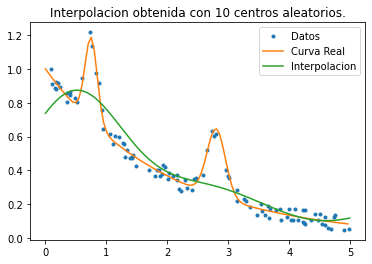

Error cuadratico medio obtenido:  0.0048916981466260836
Tiempo de entrenamiento:  0.6291899681091309 




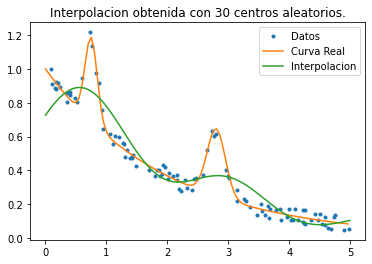

Error cuadratico medio obtenido:  0.004363417873670367
Tiempo de entrenamiento:  1.3848857879638672 




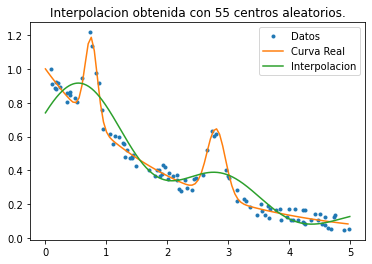

Error cuadratico medio obtenido:  0.003831099462998514
Tiempo de entrenamiento:  2.3054447174072266 




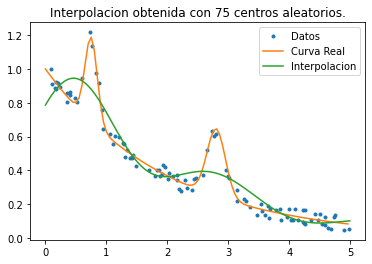

Error cuadratico medio obtenido:  0.0033740925106912545
Tiempo de entrenamiento:  3.0696113109588623 


		ENTRENAMIENTO CON PSEUDO-INVERSA:


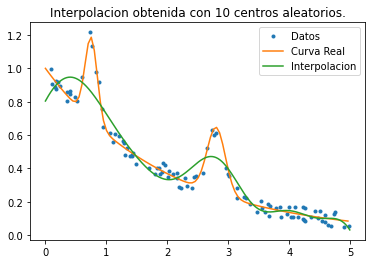

Error cuadratico medio obtenido:  0.0029007440033290326
Tiempo de entrenamiento:  0.004090547561645508 




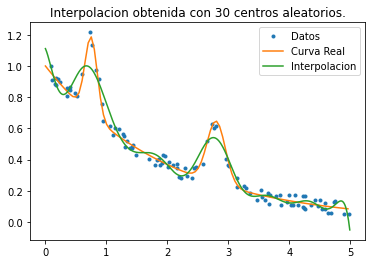

Error cuadratico medio obtenido:  0.0014694273142005132
Tiempo de entrenamiento:  0.010826826095581055 




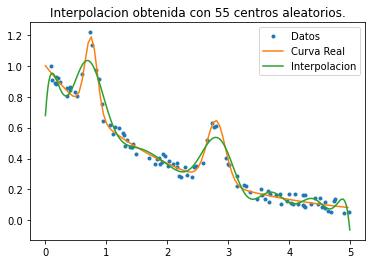

Error cuadratico medio obtenido:  0.0013099558769341139
Tiempo de entrenamiento:  0.01613759994506836 




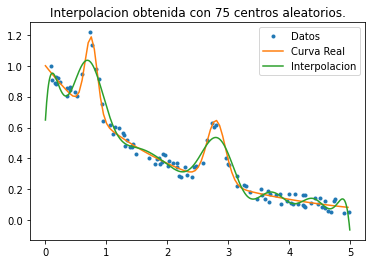

Error cuadratico medio obtenido:  0.0013138679371655624
Tiempo de entrenamiento:  0.02219390869140625 




In [ ]:
print("\033[1;1m\t\tENTRENAMIENTO CON ADALINE:")
problema2_random(True, 10, 30, 55, 75)
print("\033[1;1m\t\tENTRENAMIENTO CON PSEUDO-INVERSA:")
problema2_random(False, 10, 30, 55, 75)

Experimentamos con dos formas de obtener los pesos sinápticos: usando un adaline y la pseudo-inversa. Con gran diferencia la pseudo-inversa es superior al adaline, incluso tarda mucho menos en entrenar. En ambos casos, aumentar el número de centros más allá de $55$, siendo $50$ la mitad de los datos, no mejora mucho las predicciones.

In [ ]:
def problema2_cluster(adaline, *C):
  """ 
  Permite ejecutar el problema 2.a con distintos numeros de centros
  escogidos usando el metodo de cluster.
  INPUT:
    - adaline:  Indica si el metodo para calcular los pesos es adaline o
                pseudo-inversa.
    - C:  Conjunto de numero de centros.
  """
  for c in C:
      # Creamos la red y la entrenamos.
      rbf = RBF(X, Y, s = sqrt(0.5))
      rbf.get_centers_cluster(c, e=0.5)
      t = time()
      if adaline: ecm = rbf.train_adaline(0.001, 75, verbose=False)
      else: rbf.train_p_inv()
      t = time() - t
      
      # Graficamos la interpolacion obtenida.
      X_predict = np.array([np.array([i/100]) for i in range(500)])
      Y_predict = [rbf.predict(x_i) for x_i in X]
      plt.plot(X, Y, '.', label="Datos")
      plt.plot(X_r, Y_r, label="Curva Real")
      plt.plot(X, Y_predict, label="Interpolacion")
      plt.title("Interpolacion obtenida con " + str(c) + " centros por clusters.")
      plt.legend()
      plt.show()
      
      print("Error cuadratico medio obtenido: ", rbf.E())
      print("Tiempo de entrenamiento: ", t, "\n\n")

		ENTRENAMIENTO CON ADALINE:


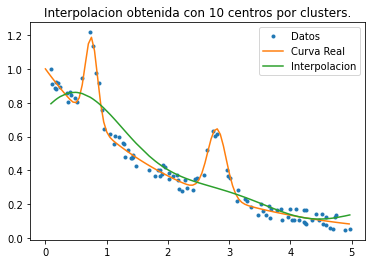

Error cuadratico medio obtenido:  0.005248149829974096
Tiempo de entrenamiento:  0.6016764640808105 




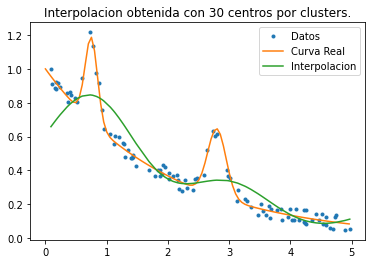

Error cuadratico medio obtenido:  0.006582682036836529
Tiempo de entrenamiento:  1.371760606765747 




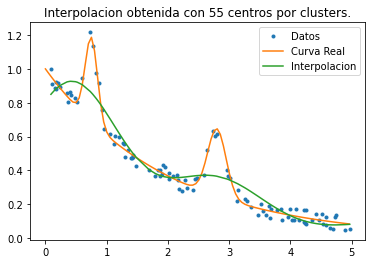

Error cuadratico medio obtenido:  0.0035595023337509114
Tiempo de entrenamiento:  2.310863733291626 




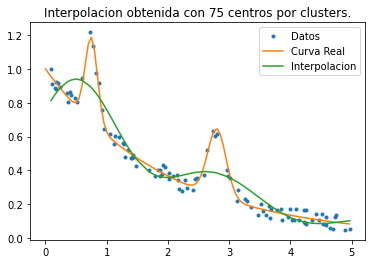

Error cuadratico medio obtenido:  0.0034608929076231122
Tiempo de entrenamiento:  3.07473087310791 


		ENTRENAMIENTO CON PSEUDO-INVERSA:


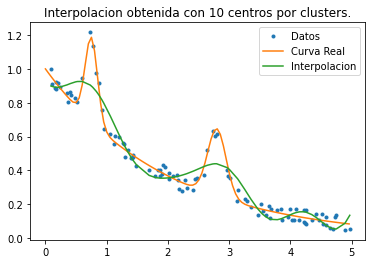

Error cuadratico medio obtenido:  0.0027618594484297002
Tiempo de entrenamiento:  0.0038971900939941406 




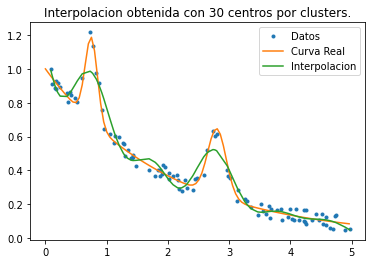

Error cuadratico medio obtenido:  0.0015767122250211468
Tiempo de entrenamiento:  0.010154962539672852 




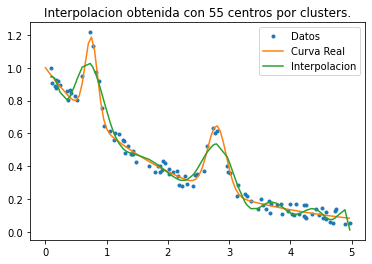

Error cuadratico medio obtenido:  0.0013146774397925249
Tiempo de entrenamiento:  0.016473770141601562 




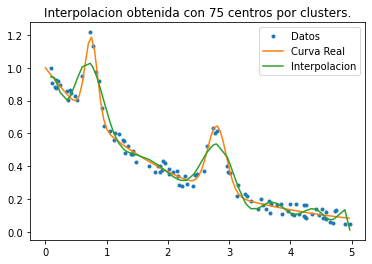

Error cuadratico medio obtenido:  0.00131294626737058
Tiempo de entrenamiento:  0.022161006927490234 




In [ ]:
print("\033[1;1m\t\tENTRENAMIENTO CON ADALINE:")
problema2_cluster(True, 10, 30, 55, 75)
print("\033[1;1m\t\tENTRENAMIENTO CON PSEUDO-INVERSA:")
problema2_cluster(False, 10, 30, 55, 75)

Las interpolaciones obtenidas en este caso son muy ligeramente superiores a las anteriores. Por lo tanto, para este problema, usar centros aleatorios o por clusters no hace tanta diferencia y se llegan a las mismas conclusiones.

### **Problema 2.b**
 Una vez determinados los centros, realice pruebas para determinar el mejor parámetro de dispersión.


In [ ]:
def problema2_b(adaline, *S):
  """ 
  Permite ejecutar el problema 2.b con distintos parametros de dispersion.
  Se usaran 50 centros correspondiente a la mitad de los datos, siguiendo
  la recomendacion teorica.
  INPUT:
    - adaline:  Indica si el metodo para calcular los pesos es adaline o
                pseudo-inversa.
    - S:  Conjunto de parametros de dispersion.
  """
  for s in S:
      # Creamos la red y la entrenamos.
      rbf = RBF(X, Y, s = s)
      rbf.get_centers_cluster(50, e=0.5)
      t = time()
      if adaline: ecm = rbf.train_adaline(0.001, 75, verbose=False)
      else: rbf.train_p_inv()
      t = time() - t
      
      # Graficamos la interpolacion obtenida.
      X_predict = np.array([np.array([i/100]) for i in range(500)])
      Y_predict = [rbf.predict(x_i) for x_i in X]
      plt.plot(X, Y, '.', label="Datos")
      plt.plot(X_r, Y_r, label="Curva Real")
      plt.plot(X, Y_predict, label="Interpolacion")
      plt.title("Interpolacion obtenida con parametro de dispersion = " + str(rbf.s))
      plt.legend()
      plt.show()
      
      print("Error cuadratico medio obtenido: ", rbf.E())
      print("Tiempo de entrenamiento: ", t, "\n\n")

		ENTRENAMIENTO CON ADALINE:


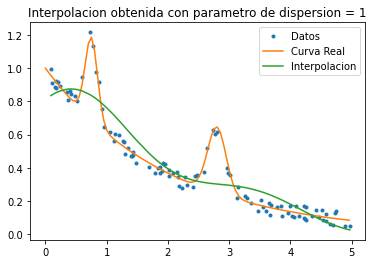

Error cuadratico medio obtenido:  0.005395355546228586
Tiempo de entrenamiento:  2.6555018424987793 




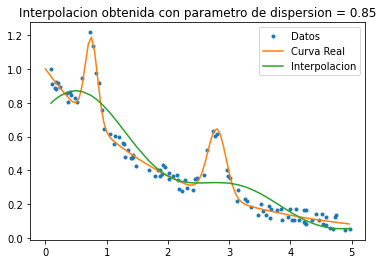

Error cuadratico medio obtenido:  0.004905815009378931
Tiempo de entrenamiento:  2.3787245750427246 




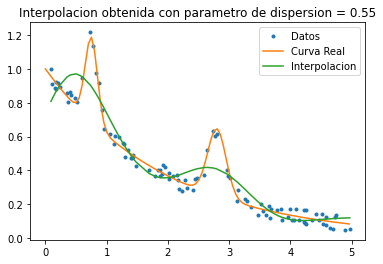

Error cuadratico medio obtenido:  0.0032805841352372273
Tiempo de entrenamiento:  2.4062840938568115 




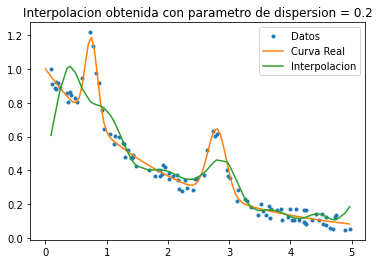

Error cuadratico medio obtenido:  0.005379200688675248
Tiempo de entrenamiento:  2.3606834411621094 




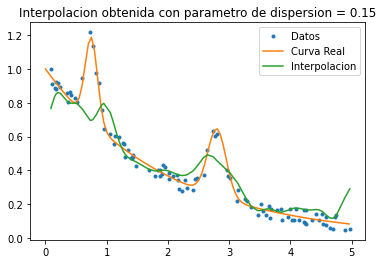

Error cuadratico medio obtenido:  0.005205704340379908
Tiempo de entrenamiento:  2.4199390411376953 




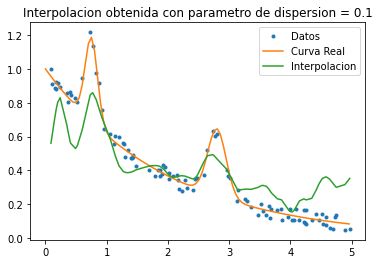

Error cuadratico medio obtenido:  0.011803642483183212
Tiempo de entrenamiento:  2.4393417835235596 


		ENTRENAMIENTO CON PSEUDO-INVERSA:


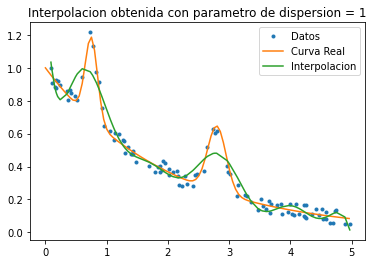

Error cuadratico medio obtenido:  0.001935327995019118
Tiempo de entrenamiento:  0.020582199096679688 




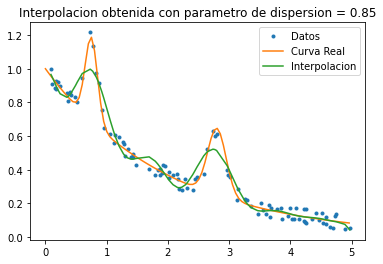

Error cuadratico medio obtenido:  0.0015228953370511986
Tiempo de entrenamiento:  0.016658544540405273 




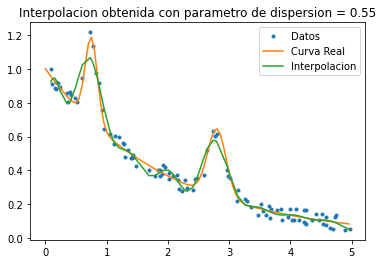

Error cuadratico medio obtenido:  0.0009077840417892659
Tiempo de entrenamiento:  0.016164541244506836 




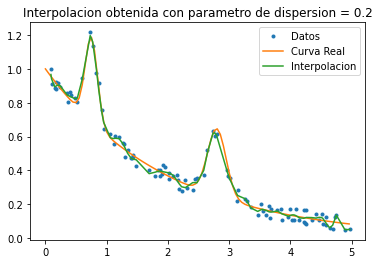

Error cuadratico medio obtenido:  0.00029626835181268134
Tiempo de entrenamiento:  0.023342132568359375 




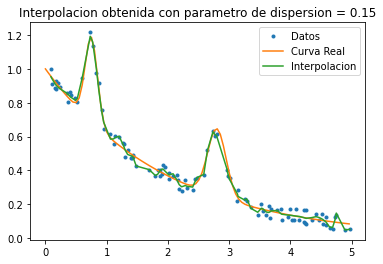

Error cuadratico medio obtenido:  0.000271012693894962
Tiempo de entrenamiento:  0.018150806427001953 




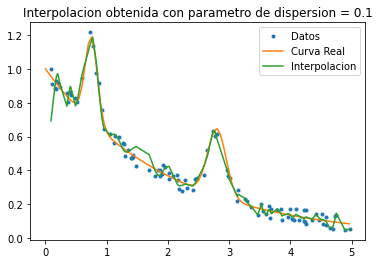

Error cuadratico medio obtenido:  0.0012277834978039635
Tiempo de entrenamiento:  0.015972137451171875 




In [ ]:
print("\033[1;1m\t\tENTRENAMIENTO CON ADALINE:")
problema2_b(True, 1, 0.85, 0.55, 0.2, 0.15, 0.1)
print("\033[1;1m\t\tENTRENAMIENTO CON PSEUDO-INVERSA:")
problema2_b(False, 1, 0.85, 0.55, 0.2, 0.15, 0.1)

Al variar el parámetro de dispersion $\sigma$ se obtuvieron resultados sorprendentes. Respecto al entrenamiento con adaline, aunque el error no mejoró, la curva obtenida fue más parecida a la original que en los experimentos anteriores. Sin embargo, para la pseudo-inversa la mejora fue total, con $\sigma = 0.15$ la curva se ajusta casi perfectamente a la original, teniendo mayor discrepancia en los extremos,. El error cuadrático medio esta en el orden de $0.0002$. En conclusión:
* Pseudo-inversa es definitivamente mejor que el adaline, siendo más eficiente y efectivo.
* Para estos datos, usar centros escogidos por cluster mejora ligeramente el resultado que escogerlos aleatoriamente.
* El parámetro de dispersión afecta significativamente las predicciones. En este caso parece que el mejor valor esta alrededor de $0.15$.

## **Problema 3**
Pruebe que $k(x, z) = k_1(x, z)k_2 (x, z)$ es un kernel si $k_1$ y $k_2$ lo son.


Sean $k_1$ y $k_2$ dos kernels tales que 

$$k_1(x, z) = \phi^t(x) \phi(z)$$ 
$$k_2(x, z) = \psi^t(x) \psi(z)$$
$$\phi^t(x) = \left[ \begin{array}{crl} \phi_1(x) & \phi_2(x) & ... & \phi_n(x) \end{array} \right]$$
$$\psi^t(x) = \left[ \begin{array}{crl} \psi_1(x) & \psi_2(x) & ... & \psi_m(x) \end{array} \right]$$ \\

Sea $k(x, z) = k_1(x, z)k_2(x, z)$, definimos 
$$\Phi^t(x) = \left[ \begin{array}{crl} \Phi_1(x) & \Phi_2(x) & ... & \Phi_{m*n}(x) \end{array} \right] $$
$$\Phi_k(x) = \phi_i(x) \psi_j(x)$$ \\

tal que $k = m*(i-1) + j$, entonces 

$$k(x, z) = k_1(x, z)k_2(x, z) = \phi^t(x) \phi(z) \psi^t(x) \psi(z)$$

$$ = 
\left[ \begin{array}{crl} \phi_1(x) & \phi_2(x) & ... & \phi_n(x) \end{array} \right] 
\left[ \begin{array}{crl} \phi_1(z) \\ \phi_2(z) \\ ... \\ \phi_n(z) \end{array} \right] 
\left[ \begin{array}{crl} \psi_1(x) & \psi_2(x) & ... & \psi_m(x) \end{array} \right] 
\left[ \begin{array}{crl} \psi_1(z) \\ \psi_2(z) \\ ... \\ \psi_m(z) \end{array} \right] 
$$

$$ = \left(\sum_{i=1}^n \phi_i(x)\phi_i(z) \right) \left( \sum_{j=i}^m \psi_j(x) \psi_j(z) \right) $$

$$ \sum_{i=1}^n \sum_{j=i}^m \phi_i(x) \psi_j(x) \phi_i(z) \psi_j(z)$$

$$ = \left[ \begin{array}{crl} \phi_1(x)\psi_1(x) & \phi_1(x) \psi_2(x) & ... & \phi_1(x) \psi_m(x) & \phi_2(x) \psi_1(x) & ... & \phi_n(x) \psi_m(x) \end{array} \right] 
\left[ \begin{array}{crl} \phi_1(z)\psi_1(z) \\ \phi_1(z) \psi_2(z) \\ ... \\ \phi_1(z) \psi_m(z) \\ \phi_2(z) \psi_1(z) \\ ... \\ \phi_n(z) \psi_m(z) \end{array} \right]$$

$$ = \left[ \begin{array}{crl} \Phi_1(x) & \Phi_2(x) & ... & \Phi_m(x) & \Phi_{m+1}(x) & ... & \Phi_{n*m}(x) \end{array} \right]  
\left[ \begin{array}{crl} \Phi_1(z) \\ \Phi_2(z) \\ ... \\ \Phi_m(z) \\ \Phi_{m+1}(z) \\ ... \\ \Phi_{n*m}(z) \end{array} \right]$$

$$ =\Phi^t(x) \Phi(z) $$


Finalmente, como podemos expresar $k(x, z)$ como $\Phi^t(x) \Phi(z)$, entonces $k(x, z) = k_1(x, z)k_2(x, z) = \Phi^t(x) \Phi(z)$ es un kernel.

## **Extra**

Ahora haremos diversas variaciones a los parametros del LMS para poder sacar su maximo potencial. Los demas parametros del RBF seran los que dieron mejores resultados en los problemas anteriores: Centros por conglomerados y 0.2 de dispersion.

In [18]:
def extra(epochs, *N):
  """ 
  Permite ejecutar el problema 2.b con distintos parametros de dispersion.
  Se usaran 50 centros correspondiente a la mitad de los datos, siguiendo
  la recomendacion teorica.
  INPUT:
    - S:  Conjunto de parametros de dispersion.
  """
  for n in N:
      # Creamos la red y la entrenamos.
      rbf = RBF(X, Y, s = 0.2)
      rbf.get_centers_cluster(50, e=0.5)
      t = time()
      ecm = rbf.train_adaline(n, epochs, verbose=False)
      t = time() - t

      print("\t\t\033[1;1mPARA ETHA = " + str(n) + "\033[0;1m")
      # Graficamos el error cuadratico medio
      plt.plot([i+1 for i in range(epochs)], ecm)
      plt.title("Evolucion del Error Cuadratico Medio.")
      plt.show()
      
      # Graficamos la interpolacion obtenida.
      X_predict = np.array([np.array([i/100]) for i in range(500)])
      Y_predict = [rbf.predict(x_i) for x_i in X]
      plt.plot(X, Y, '.', label="Datos")
      plt.plot(X_r, Y_r, label="Curva Real")
      plt.plot(X, Y_predict, label="Interpolacion")
      plt.title("Interpolacion obtenida con parametro de dispersion = " + str(rbf.s))
      plt.legend()
      plt.show()
      print("Minimo ECM: " + str(min(ecm)) + "\n\n")

		PARA ETHA = 0.0001


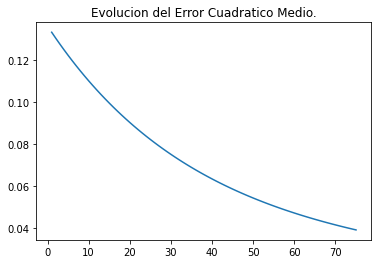

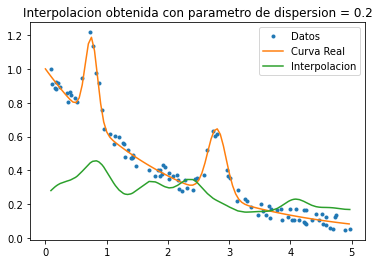

Minimo ECM: 0.039208692786559834


		PARA ETHA = 0.001


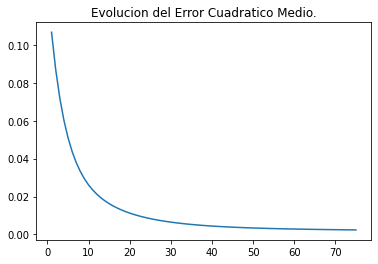

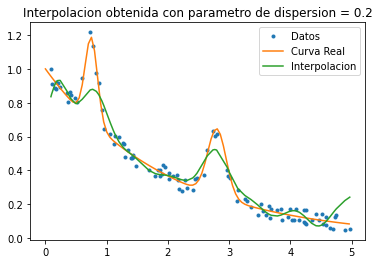

Minimo ECM: 0.0024158263834105943


		PARA ETHA = 0.01


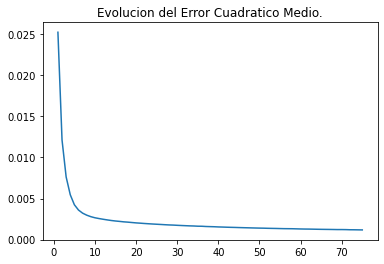

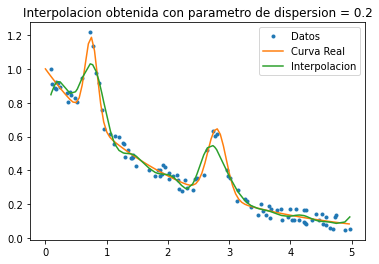

Minimo ECM: 0.0011780581699814994


		PARA ETHA = 0.05


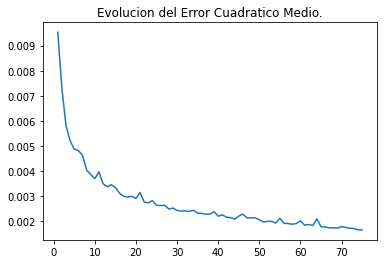

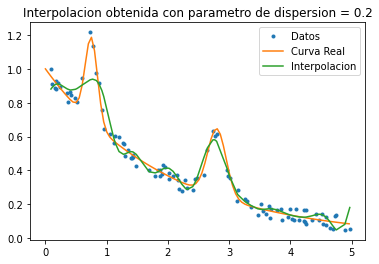

Minimo ECM: 0.0016483243130465894


		PARA ETHA = 0.1


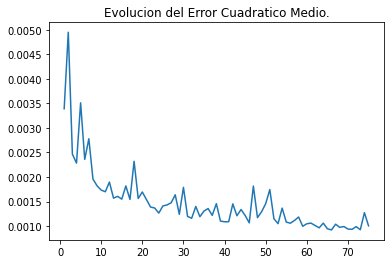

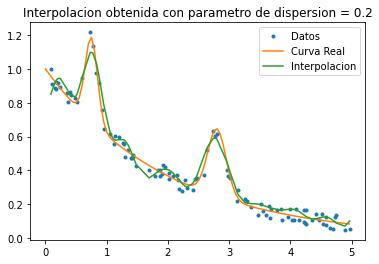

Minimo ECM: 0.0009213223807947243




In [19]:
extra(75, 0.0001, 0.001, 0.01, 0.05, 0.1)

		PARA ETHA = 0.0001


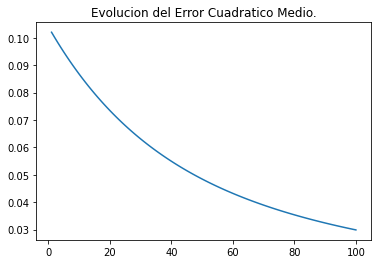

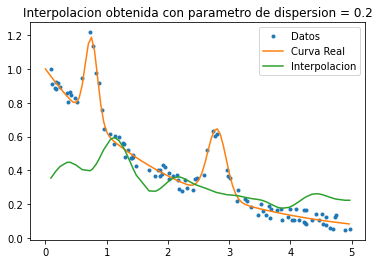

Minimo ECM: 0.029863302699510014


		PARA ETHA = 0.001


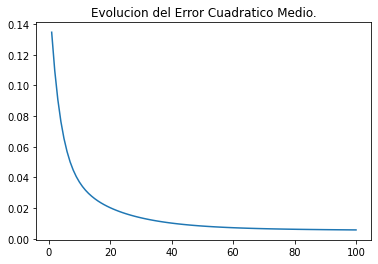

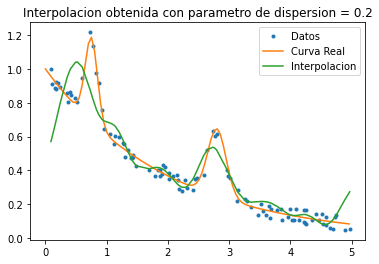

Minimo ECM: 0.005827834413483382


		PARA ETHA = 0.01


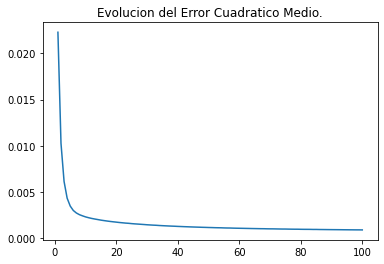

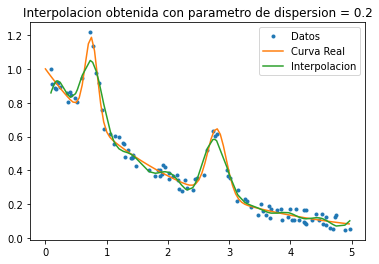

Minimo ECM: 0.000916905259590447


		PARA ETHA = 0.05


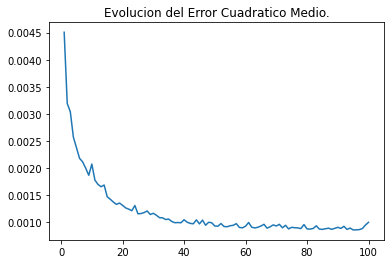

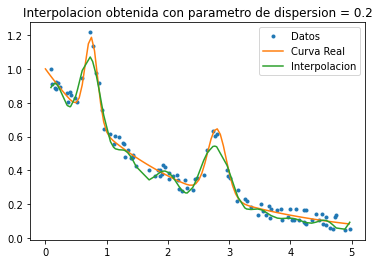

Minimo ECM: 0.0008590517898198523


		PARA ETHA = 0.1


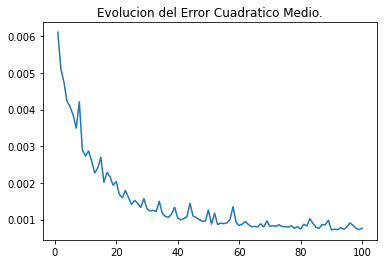

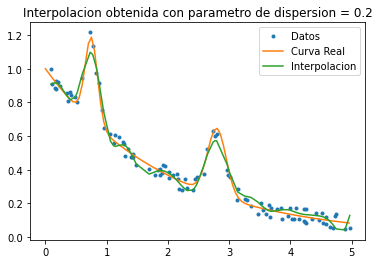

Minimo ECM: 0.0007172396519882302




In [20]:
extra(100, 0.0001, 0.001, 0.01, 0.05, 0.1)

		PARA ETHA = 0.0001


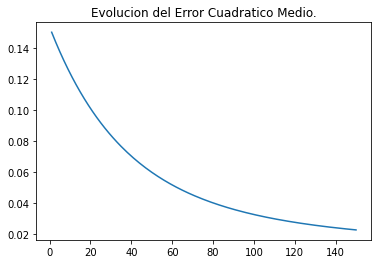

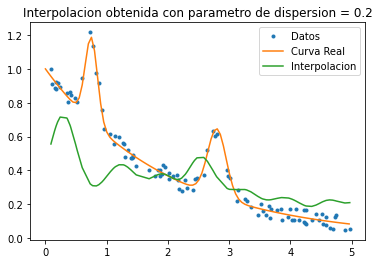

Minimo ECM: 0.02272015372409768


		PARA ETHA = 0.001


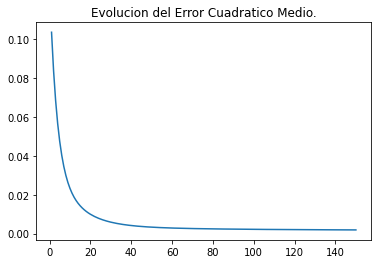

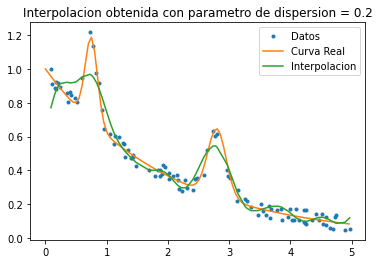

Minimo ECM: 0.0018572308259623934


		PARA ETHA = 0.01


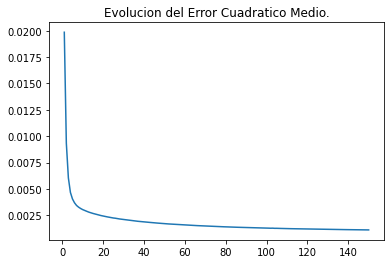

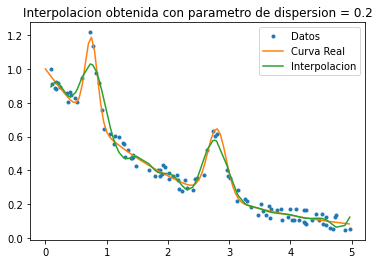

Minimo ECM: 0.0011205331368932105


		PARA ETHA = 0.05


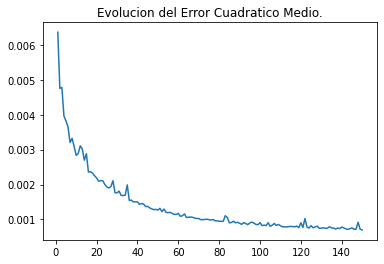

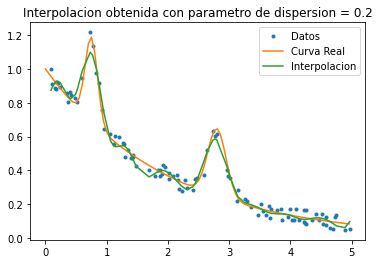

Minimo ECM: 0.0006997512921483349


		PARA ETHA = 0.1


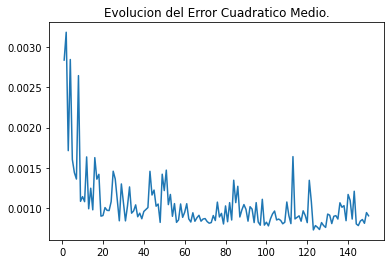

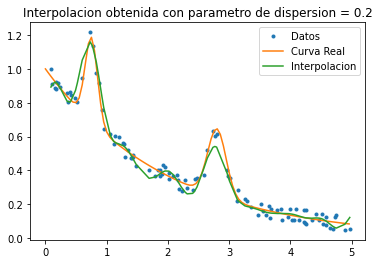

Minimo ECM: 0.0007339890013385905




In [21]:
extra(150, 0.0001, 0.001, 0.01, 0.05, 0.1)

		PARA ETHA = 0.0001


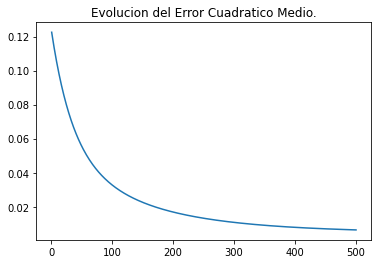

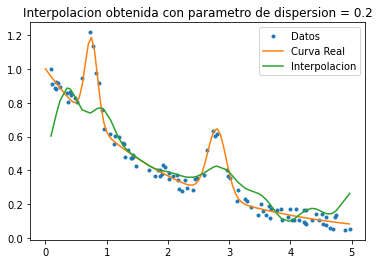

Minimo ECM: 0.006395701303921394


		PARA ETHA = 0.001


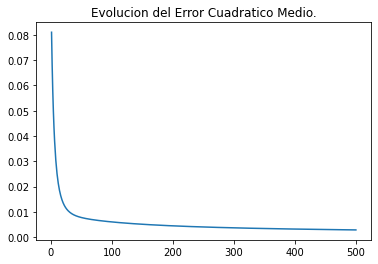

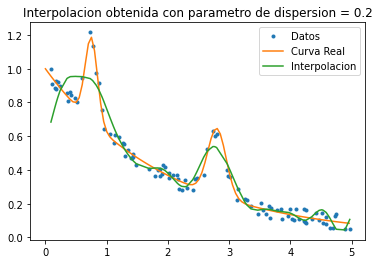

Minimo ECM: 0.002868650061452147


		PARA ETHA = 0.01


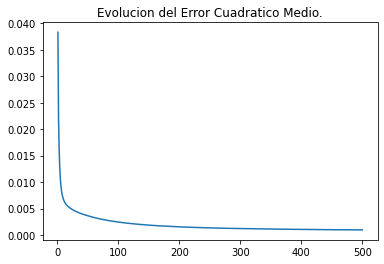

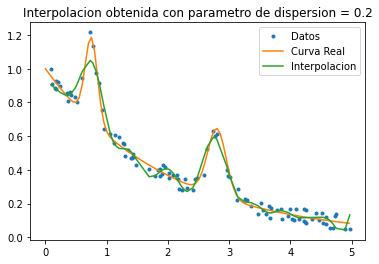

Minimo ECM: 0.0009669424818077365


		PARA ETHA = 0.05


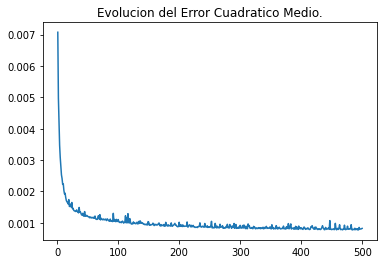

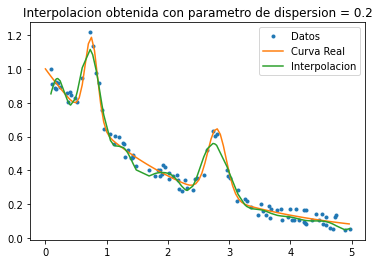

Minimo ECM: 0.0007736432849271894


		PARA ETHA = 0.1


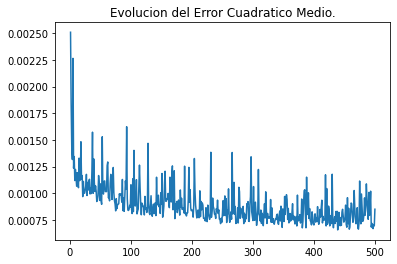

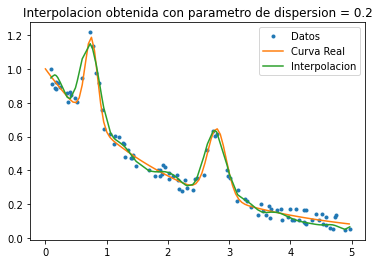

Minimo ECM: 0.0006573932896478109




In [22]:
extra(500, 0.0001, 0.001, 0.01, 0.05, 0.1)

		PARA ETHA = 0.0001


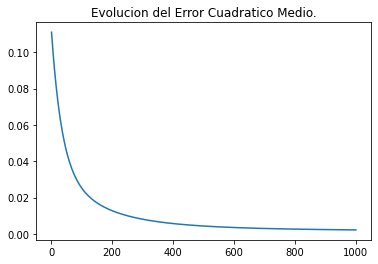

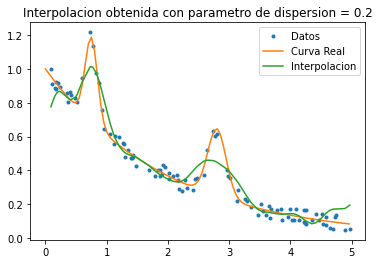

Minimo ECM: 0.002263606635981925


		PARA ETHA = 0.001


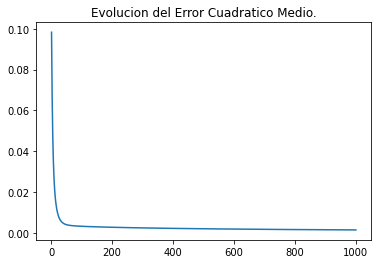

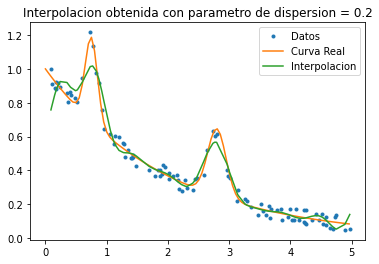

Minimo ECM: 0.0015477326294996774


		PARA ETHA = 0.01


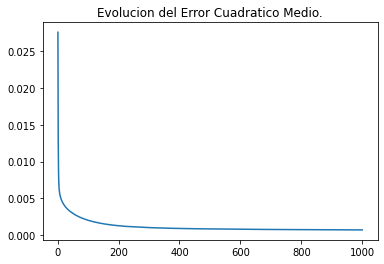

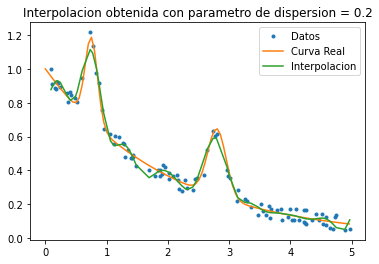

Minimo ECM: 0.000678480319587504


		PARA ETHA = 0.05


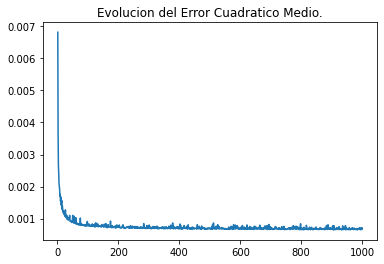

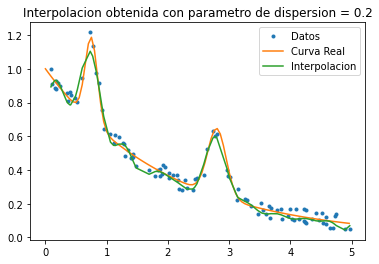

Minimo ECM: 0.0006472984410150963


		PARA ETHA = 0.1


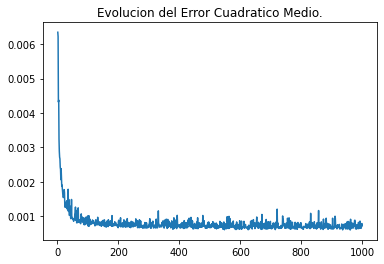

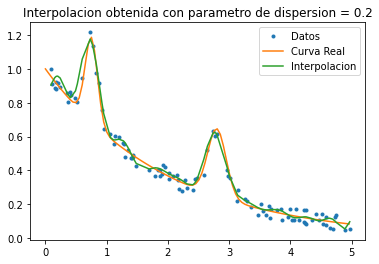

Minimo ECM: 0.0006084091934129179




In [23]:
extra(1000, 0.0001, 0.001, 0.01, 0.05, 0.1)

### **Nuevas Conclusiones:**
Hizo falta experimentar mas con el LMS antes de sacar conclusiones sobre su capacidad. En este experimento extra se demostro que el LMS puede rivalizar con la pseudo-inversa, dando resultado muy buenos y cercanos a la curva original, a pesar del error en los datos de entrenamiento.